## RNN + GloVe Embedding Model

Import packages

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn import preprocessing
from tqdm import tqdm
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Activation, Dropout

In [262]:
columns = ["id",
           "label",
           "statement",
           "subject",
           "speaker",
           "job_title",
           "state_info",
           "party_affiliation",
           "barely_true_counts",
           "false_counts",
           "half_true_counts",
           "mostly_true_counts",
           "pants_on_fire_counts",
           "context"]

df_test = pd.read_csv("test.tsv", names=columns,sep='\t')
df_train = pd.read_csv("train.tsv", names=columns,sep='\t')
df_valid = pd.read_csv("valid.tsv", names=columns,sep='\t')

In [263]:
df_test.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [264]:
# cleaning the statements
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text


df_test['statement_clean'] = df_test.statement.apply(clean_text)
df_train['statement_clean'] = df_train.statement.apply(clean_text)
df_valid['statement_clean'] = df_valid.statement.apply(clean_text)

In [266]:
df_test.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,statement_clean
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,building wall usmexico border take literally y...
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace double number layoffs year
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,says john mccain done nothing help vets
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,suzanne bonamici supports plan cut choice medi...
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,asked reporter whether hes center criminal sch...


In [267]:
# encode the label
encoder_ = preprocessing.LabelEncoder()
df_train['label_enc'] = encoder_.fit_transform(df_train['label'])
df_test['label_enc'] = encoder_.transform(df_test['label'])
df_valid['label_enc'] = encoder_.transform(df_valid['label'])

In [268]:
list(encoder_.classes_)

['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']

In [269]:
def mapping_label(s):
    label_mapping = {"pants-fire": 0, "false": 0, "barely-true": 0, "half-true": 0, "mostly-true": 1, "true": 1}
    return label_mapping.get(s.lower(), -1)
    
df_train['integer_label'] = df_train.label.apply(mapping_label)
df_test['integer_label'] = df_test.label.apply(mapping_label)
df_valid['integer_label'] = df_valid.label.apply(mapping_label)

In [271]:
df_test.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,statement_clean,label_enc,integer_label
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,building wall usmexico border take literally y...,5,1
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace double number layoffs year,1,0
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,says john mccain done nothing help vets,1,0
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,suzanne bonamici supports plan cut choice medi...,2,0
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,asked reporter whether hes center criminal sch...,4,0


Load GloVe vectors, trying both Wikipedia/Gigaword and the Twitter vectors

In [272]:
embeddings_glove6b = {}
f = open('glove6b/glove.6B.100d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_glove6b[word] = coefs
f.close()
print('Found %s word vectors.'% len(embeddings_glove6b))

400001it [00:13, 29755.81it/s]

Found 400001 word vectors.


In [273]:
len(embeddings_glove6b)

400001

In [274]:
embeddings_glovetwt = {}
f = open('glovetwitter/glove.twitter.27B.100d.txt',encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_glovetwt[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_glovetwt))

1193517it [00:39, 30402.00it/s]

Found 1193515 word vectors.


In [275]:
VOCABULARY_SIZE = 10000
MAX_LENGTH = 60

tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(df_train['statement_clean']) 
                       + list(df_valid['statement_clean']) 
                       + list(df_test['statement_clean']))


In [276]:
x_train = tokenizer.texts_to_sequences(df_train['statement_clean'])
x_test = tokenizer.texts_to_sequences(df_test['statement_clean'])
x_valid = tokenizer.texts_to_sequences(df_valid['statement_clean'])

# pad

xtrain_padding = sequence.pad_sequences(x_train, maxlen=MAX_LENGTH)
xtest_padding = sequence.pad_sequences(x_test, maxlen=MAX_LENGTH)
xvalid_padding = sequence.pad_sequences(x_valid, maxlen=MAX_LENGTH)

word_index = tokenizer.word_index

In [277]:
embedding_matrix_6b = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_glove6b.get(word)
    if embedding_vector is not None:
        embedding_matrix_6b[i] = embedding_vector

100%|██████████| 14590/14590 [00:00<00:00, 388785.87it/s]


In [278]:
embedding_matrix_twt = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_glovetwt.get(word)
    if embedding_vector is not None:
        embedding_matrix_twt[i] = embedding_vector

100%|██████████| 14590/14590 [00:00<00:00, 607864.11it/s]


In [279]:
ytrain_encode = np_utils.to_categorical(df_train['label_enc'])
ytest_encode = np_utils.to_categorical(df_test['label_enc'])
yvalid_encode = np_utils.to_categorical(df_valid['label_enc'])

ytrain_encode2 = np_utils.to_categorical(df_train['integer_label'])
ytest_encode2 = np_utils.to_categorical(df_test['integer_label'])
yvalid_encode2 = np_utils.to_categorical(df_valid['integer_label'])


In [280]:
model_glove6b = Sequential()

model_glove6b.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix_6b], input_length=MAX_LENGTH, trainable=False))
model_glove6b.add(SpatialDropout1D(0.3))
model_glove6b.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model_glove6b.add(Dense(1024, activation='relu'))
model_glove6b.add(Dropout(0.8))
model_glove6b.add(Dense(1024, activation='relu'))
model_glove6b.add(Dropout(0.8))
model_glove6b.add(Dense(2))
model_glove6b.add(Activation('softmax'))
model_glove6b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [296]:
model_twt = Sequential()

model_twt.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix_twt], input_length=MAX_LENGTH, trainable=False))
model_twt.add(SpatialDropout1D(0.3))
model_twt.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model_twt.add(Dense(1024, activation='relu'))
model_twt.add(Dropout(0.5))
model_twt.add(Dense(1024, activation='relu'))
model_twt.add(Dense(2))
model_twt.add(Activation('softmax'))
model_twt.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [282]:
history_glove6b = model_glove6b.fit(xtrain_padding, y=ytrain_encode2, batch_size=128, epochs=10, verbose=1, 
                        validation_data=(xvalid_padding, yvalid_encode2))

Epoch 1/10
80/80 [==============================] - 18s 136ms/step - loss: 0.6573 - accuracy: 0.6426 - val_loss: 0.6361 - val_accuracy: 0.6752
Epoch 2/10
80/80 [==============================] - 10s 123ms/step - loss: 0.6508 - accuracy: 0.6430 - val_loss: 0.6183 - val_accuracy: 0.6737
Epoch 3/10
80/80 [==============================] - 10s 119ms/step - loss: 0.6469 - accuracy: 0.6435 - val_loss: 0.6181 - val_accuracy: 0.6721
Epoch 4/10
80/80 [==============================] - 11s 133ms/step - loss: 0.6421 - accuracy: 0.6414 - val_loss: 0.6200 - val_accuracy: 0.6807
Epoch 5/10
80/80 [==============================] - 10s 121ms/step - loss: 0.6393 - accuracy: 0.6441 - val_loss: 0.6225 - val_accuracy: 0.6752
Epoch 6/10
80/80 [==============================] - 10s 122ms/step - loss: 0.6381 - accuracy: 0.6460 - val_loss: 0.6087 - val_accuracy: 0.6667
Epoch 7/10
80/80 [==============================] - 10s 128ms/step - loss: 0.6368 - accuracy: 0.6470 - val_loss: 0.6177 - val_accuracy: 0.6737

In [297]:
history_twt = model_twt.fit(xtrain_padding, y=ytrain_encode2, batch_size=128, epochs=10, verbose=1, 
                            validation_data=(xvalid_padding, yvalid_encode2))

Epoch 1/10
80/80 [==============================] - 22s 185ms/step - loss: 0.6506 - accuracy: 0.6447 - val_loss: 0.6509 - val_accuracy: 0.6690
Epoch 2/10
80/80 [==============================] - 15s 189ms/step - loss: 0.6462 - accuracy: 0.6437 - val_loss: 0.6102 - val_accuracy: 0.6729
Epoch 3/10
80/80 [==============================] - 16s 200ms/step - loss: 0.6385 - accuracy: 0.6433 - val_loss: 0.6109 - val_accuracy: 0.6791
Epoch 4/10
80/80 [==============================] - 18s 223ms/step - loss: 0.6350 - accuracy: 0.6448 - val_loss: 0.6085 - val_accuracy: 0.6807
Epoch 5/10
80/80 [==============================] - 18s 223ms/step - loss: 0.6363 - accuracy: 0.6479 - val_loss: 0.6141 - val_accuracy: 0.6776
Epoch 6/10
80/80 [==============================] - 18s 220ms/step - loss: 0.6308 - accuracy: 0.6521 - val_loss: 0.6079 - val_accuracy: 0.6776
Epoch 7/10
80/80 [==============================] - 17s 211ms/step - loss: 0.6268 - accuracy: 0.6527 - val_loss: 0.6351 - val_accuracy: 0.6246

In [309]:
loss, accuracy = model_twt.evaluate(xtest_padding)

40/40 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


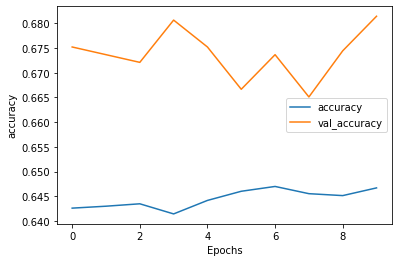

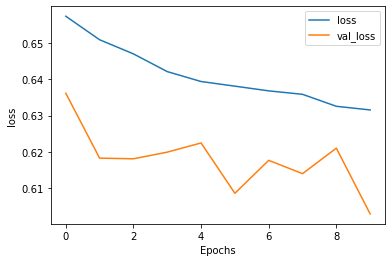

In [311]:
def graph_plots(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

graph_plots(history_glove6b, "accuracy")
graph_plots(history_glove6b, "loss")